In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!git clone https://github.com/UCMerced-ML/LC-model-compression

Cloning into 'LC-model-compression'...
remote: Enumerating objects: 166, done.
remote: Counting objects: 100% (166/166), done.
remote: Compressing objects: 100% (121/121), done.
remote: Total 166 (delta 63), reused 142 (delta 42), pack-reused 0
Receiving objects: 100% (166/166), 3.19 MiB | 33.99 MiB/s, done.
Resolving deltas: 100% (63/63), done.


In [ ]:
%cd /content/drive/My \Drive/NLA_project/LC-model-compression

[Errno 2] No such file or directory: '/content/drive/My Drive/NLA_project/LC-model-compression'
/content


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
from collections import OrderedDict

transform = transforms.Compose(
                                [transforms.Resize((256,256)),
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

cuda:0


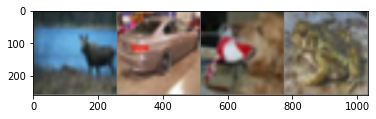

deer  car   dog   frog 


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [ ]:

class CaffeBNAlexNet(nn.Module):
  def __init__(self, num_classes=10):
    super(CaffeBNAlexNet, self).__init__()
    self.features = nn.Sequential(
      nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2),
      nn.BatchNorm2d(96),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=3, stride=2),

      nn.Conv2d(96, 256, kernel_size=5, padding=2),
      nn.BatchNorm2d(256),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=3, stride=2),

      nn.Conv2d(256, 384, kernel_size=3, padding=1),
      nn.BatchNorm2d(384),
      nn.ReLU(inplace=True),

      nn.Conv2d(384, 384, kernel_size=3, padding=1),
      nn.BatchNorm2d(384),
      nn.ReLU(inplace=True),

      nn.Conv2d(384, 256, kernel_size=3, padding=0),
      nn.BatchNorm2d(256),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=3, stride=2),
    )
    self.classifier = nn.Sequential(
      nn.Linear(256 * 6 * 6, 4096),
      nn.BatchNorm1d(4096),
      nn.ReLU(inplace=True),
      nn.Dropout(),
      nn.Linear(4096, 4096),
      nn.BatchNorm1d(4096),
      nn.ReLU(inplace=True),
      nn.Dropout(),
      nn.Linear(4096, num_classes),
    )
    self.loss = lambda x, target: nn.CrossEntropyLoss()(x, target)


  def forward(self, x):
    x = self.features(x)
    x = torch.flatten(x, 1)
    x = self.classifier(x)
    return x

In [ ]:
model1 = CaffeBNAlexNet()

In [ ]:
model1.to(device)

CaffeBNAlexNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14):

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model1.parameters(), lr=0.01, momentum=0.9)


In [ ]:
import time
import datetime

flops = []
counter = 0
start_time = time.time()
for epoch in range(2): 
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()
        #high.start_counters([events.PAPI_FP_OPS,])

        outputs = model1(inputs)
        #x=high.stop_counters()
        #flops.append(x)
        counter += 1
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:   
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0
elapsed_time = time.time() - start_time

RuntimeError: ignored

In [ ]:
str(datetime.timedelta(seconds=elapsed_time))

'0:07:04.160323'

In [ ]:
PATH = '/content/drive/My Drive/NLA project/cifar_alexnet1.pth'
torch.save(model1.state_dict(), PATH)

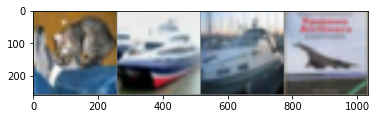

GroundTruth:  cat   ship  ship  plane


In [ ]:
dataiter = iter(testloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [ ]:
outputs = model1(images.to(device))
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(4)))

Predicted:  dog   car   truck plane


In [ ]:
def low_rank_dec(filters, rank):
    f = filters.shape[0]
    w = []

    for filter in range(f):
      w_flat = filters[filter].flatten()
      _dim = len(w_flat)
      w.append(w_flat.reshape(1, _dim))

    W = torch.cat(tuple(w), 0)
    W = W.detach().numpy()

    ck1k2 = list(filters.shape[1:])

    u, s, vh = np.linalg.svd(W)
    u.shape, s.shape, vh.shape

    U, S, V = u[:, :rank], s[:rank], vh[:rank, :]

    U_new = U 
    V_new = np.diag(S) @ V

    assert np.allclose(U_new @ V_new, U @ np.diag(S) @ V)


    U_layer = torch.Tensor(U_new).unsqueeze(dim=-1).unsqueeze(dim=-1)
    V_layer = torch.Tensor(V_new).reshape(rank, ck1k2[0], ck1k2[1], ck1k2[2])


    return U_layer, V_layer

In [ ]:
def generate_low_rank_conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1,
                             bias=True, padding_mode='zeros', rank=None, scheme='scheme_1'):
  if rank is None:
    return nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding,
                     dilation=dilation, groups=groups, bias=bias)
  if scheme == 'scheme_1':
    conv1 = nn.Conv2d(in_channels, out_channels, kernel_size)
    filters = conv1.weight
    u, v = low_rank_dec(filters, rank)

    l1 = nn.Conv2d(in_channels=in_channels,
                   out_channels=rank,
                   kernel_size=kernel_size,
                   stride=stride,
                   padding=padding,
                   dilation=dilation,
                   groups=groups,
                   bias=False
                   )
    l1.load_state_dict({'weight': v}, strict=False)
    l2 = nn.Conv2d(in_channels=rank, out_channels=out_channels,
                   kernel_size=1,
                   bias=bias)
    
    l2.load_state_dict({'weight': u}, strict=False)
    
    return nn.Sequential(OrderedDict([('V', l1), ('U', l2)]))
  elif scheme == 'scheme_2':
    if isinstance(kernel_size, int):
      kernel_size = [kernel_size, kernel_size]

    if isinstance(padding, int):
      padding = [padding, padding]
    if isinstance(stride, int):
      stride = [stride, stride]

    l1 = nn.Conv2d(in_channels=in_channels,
                   out_channels=rank,
                   kernel_size=(1, kernel_size[1]),
                   stride=(1, stride[1]),
                   padding=(0, padding[1]),
                   dilation=dilation,
                   groups=groups,
                   bias=False
                   )
    
    l2 = nn.Conv2d(in_channels=rank,
                   out_channels=out_channels,
                   kernel_size=(kernel_size[0], 1),
                   padding=(padding[0], 0),
                   stride=(stride[0], 1),
                   bias=bias)
    

    return nn.Sequential(OrderedDict([('V', l1), ('U', l2)]))

def generate_low_rank_linear(in_features, out_features, bias=True, rank=None):
  if rank is None:
    return nn.Linear(in_features, out_features, bias=bias)
  l1 = nn.Linear(in_features=in_features, out_features=rank, bias=False)
  l2 = nn.Linear(in_features=rank, out_features=out_features, bias=bias)
  return nn.Sequential(OrderedDict([('V', l1), ('U', l2)]))

class CaffeBNLowRankAlexNet(nn.Module):
  def __init__(self, ranks, scheme, num_classes=10):
    super(CaffeBNLowRankAlexNet, self).__init__()
    self.features = nn.Sequential(
      generate_low_rank_conv2d(3, 96, kernel_size=11, stride=4, padding=2, rank=ranks[0], scheme=scheme),
      nn.BatchNorm2d(96),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=3, stride=2),

      generate_low_rank_conv2d(96, 256, kernel_size=5, padding=2, rank=ranks[1], scheme=scheme),
      nn.BatchNorm2d(256),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=3, stride=2),

      generate_low_rank_conv2d(256, 384, kernel_size=3, padding=1, rank=ranks[2], scheme=scheme),
      nn.BatchNorm2d(384),
      nn.ReLU(inplace=True),

      generate_low_rank_conv2d(384, 384, kernel_size=3, padding=1, rank=ranks[3], scheme=scheme),
      nn.BatchNorm2d(384),
      nn.ReLU(inplace=True),

      generate_low_rank_conv2d(384, 256, kernel_size=3, padding=0, rank=ranks[4], scheme=scheme),
      nn.BatchNorm2d(256),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=3, stride=2),
    )
    self.classifier = nn.Sequential(
      generate_low_rank_linear(256 * 6 * 6, 4096, rank=ranks[5]),
      nn.BatchNorm1d(4096),
      nn.ReLU(inplace=True),
      nn.Dropout(),
      generate_low_rank_linear(4096, 4096, rank=ranks[6]),
      nn.BatchNorm1d(4096),
      nn.ReLU(inplace=True),
      nn.Dropout(),
      generate_low_rank_linear(4096, num_classes, rank=ranks[7]),
    )
    self.loss = lambda x, target: nn.CrossEntropyLoss()(x, target)

  def forward(self, x):
    x = self.features(x)
    x = torch.flatten(x, 1)
    x = self.classifier(x)
    return x


In [ ]:
#Scheme 2
ranks1 = [7, 28, 69, 71, 88, 506, 349, 255]
ranks2 = [8, 28, 76, 79, 99, 606, 428, 288]
ranks3 = [8, 30, 85, 90, 114, 770, 582, 341]
ranks4 = [9, 34, 103, 116, 143, 1075, 937, 449]
ranks5 = [11, 46, 148, 172, 199, 1790, 1733, 694]

#Scheme 1
ranks6 = [25, 31, 76, 62, 76, 602, 429, 290]
ranks7 = [26, 34, 79, 66, 82, 688, 507, 318]
ranks8 = [27, 33, 82, 71, 87, 760, 586, 344]
ranks9 = [33, 53, 133, 134, 156, 1764, 1748, 703]

model2 = CaffeBNLowRankAlexNet(ranks=ranks1, scheme='scheme_1')
model2.to(device)

CaffeBNLowRankAlexNet(
  (features): Sequential(
    (0): Sequential(
      (V): Conv2d(3, 7, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2), bias=False)
      (U): Conv2d(7, 96, kernel_size=(1, 1), stride=(1, 1))
    )
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Sequential(
      (V): Conv2d(96, 28, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
      (U): Conv2d(28, 256, kernel_size=(1, 1), stride=(1, 1))
    )
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Sequential(
      (V): Conv2d(256, 69, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (U): Conv2d(69, 384, kernel_size=(1, 1), stride=(1, 1))
    )
    (9): BatchN

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model2.parameters(), lr=0.01, momentum=0.9)


In [ ]:
import time
import datetime

start_time = time.time()
for epoch in range(2): 
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = model2(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:   
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

elapsed_time = time.time() - start_time
print(elapsed_time)

[1,  2000] loss: 35.569
[1,  4000] loss: 2.314
[1,  6000] loss: 2.312


KeyboardInterrupt: ignored

In [ ]:
import datetime
str(datetime.timedelta(seconds=elapsed_time))

'0:07:04.160323'

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 12, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(12 * 64 * 64, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))


        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net1 = Net()
net1.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=49152, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net1.parameters(), lr=0.001, momentum=0.9)

In [ ]:
import time
import datetime

flops = []
counter = 0
start_time = time.time()
for epoch in range(2): 
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = net1(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:   
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0
elapsed_time = time.time() - start_time

[1,  2000] loss: 1.946
[1,  4000] loss: 1.692
[1,  6000] loss: 1.621
[1,  8000] loss: 1.579
[1, 10000] loss: 1.564
[1, 12000] loss: 1.533
[2,  2000] loss: 1.476
[2,  4000] loss: 1.443
[2,  6000] loss: 1.440
[2,  8000] loss: 1.472
[2, 10000] loss: 1.452
[2, 12000] loss: 1.438


In [ ]:
import datetime
str(datetime.timedelta(seconds=elapsed_time))

'0:04:30.997772'

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self, ranks, scheme):
        super().__init__()
        self.conv1 = generate_low_rank_conv2d(3, 6, kernel_size=3, stride=1, padding=1, rank=ranks[0], scheme=scheme)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = generate_low_rank_conv2d(6, 12, kernel_size=3, stride=1, padding=1, rank=ranks[1], scheme=scheme)
        self.fc1 = generate_low_rank_linear(12 * 64 * 64, 120, ranks[0])
        self.fc2 = generate_low_rank_linear(120, 84, ranks[1])
        self.fc3 = generate_low_rank_linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [ ]:
ranks = [2, 12]

net2 = Net(ranks, scheme='scheme_1')
net2.to(device)

Net(
  (conv1): Sequential(
    (V): Conv2d(3, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (U): Conv2d(2, 6, kernel_size=(1, 1), stride=(1, 1))
  )
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Sequential(
    (V): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (U): Conv2d(12, 12, kernel_size=(1, 1), stride=(1, 1))
  )
  (fc1): Linear(in_features=49152, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net2.parameters(), lr=0.001, momentum=0.9)

In [ ]:
import time
import datetime

flops = []
counter = 0
start_time = time.time()
for epoch in range(2): 
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = net2(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:   
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0
elapsed_time = time.time() - start_time

KeyboardInterrupt: ignored

In [ ]:
import datetime
str(datetime.timedelta(seconds=elapsed_time))

'0:04:37.078110'

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

In [ ]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 10):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3),
                        nn.BatchNorm2d(64),
                        nn.ReLU())
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(2048, num_classes)
        
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [ ]:
resnet = ResNet(ResidualBlock, [3, 4, 6, 3]).to(device)

In [ ]:
num_classes = 10
num_epochs = 20
batch_size = 16
learning_rate = 0.01

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet.parameters(), lr=learning_rate, weight_decay = 0.001, momentum = 0.9)  

total_step = len(trainloader)

In [ ]:
import time
import datetime

flops = []
counter = 0
start_time = time.time()
for epoch in range(2): 
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = resnet(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:   
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0
elapsed_time = time.time() - start_time

[1,  2000] loss: 2.344
[1,  4000] loss: 1.992
[1,  6000] loss: 1.851
[1,  8000] loss: 1.751
[1, 10000] loss: 1.653
[1, 12000] loss: 1.605
[2,  2000] loss: 1.459
[2,  4000] loss: 1.366
[2,  6000] loss: 1.303
[2,  8000] loss: 1.208
[2, 10000] loss: 1.154
[2, 12000] loss: 1.088


In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
                        generate_low_rank_conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        generate_low_rank_conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

In [ ]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 10):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                        generate_low_rank_conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3, rank=),
                        nn.BatchNorm2d(64),
                        nn.ReLU())
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(2048, num_classes)
        
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            
            downsample = nn.Sequential(
                generate_low_rank_conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [ ]:
PATH = '/content/drive/My Drive/NLA project/cifar_alexnet2.pth'
torch.save(model1.state_dict(), PATH)


In [ ]:
dataiter = iter(testloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [ ]:
outputs = model1(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(4)))

In [ ]:
print(os.getcwd())

/content/drive/My Drive/NLA project/LC-model-compression/examples/low_rank_alexnets


In [ ]:
%cd /content/drive/My \Drive/NLA \project

/content/drive/My Drive/NLA project


In [ ]:
!pip install -e ./LC-model-compression

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/drive/My%20Drive/NLA%20project/LC-model-compression
  Attempting uninstall: lc
    Found existing installation: lc 0.1
    Can't uninstall 'lc'. No files were found to uninstall.
  Running setup.py develop for lc


In [ ]:
%cd LC-model-compression

/content/drive/My Drive/NLA project/LC-model-compression


In [ ]:
model1.features[0]

Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))

In [ ]:
import lc
from lc.torch import ParameterTorch as Param, AsVector
from lc.compression_types import AdaptiveQuantization

l1 = model1.features[0]
device1 = torch.device('cuda')
p1 = Param(l1.weight,device1)
p1 = Param(l1.weight, device=device)
compression_tasks = {Param(l1.weight, device=device): (AsVector, AdaptiveQuantization(k=2))
    #Param(l2.weight): (AsVector, AdaptiveQuantization(k=2)),
    #Param(l3.weight): (AsVector, AdaptiveQuantization(k=2))
}   

def my_l_step(model, lc_penalty, step):
    params = list(filter(lambda p: p.requires_grad, model.parameters()))
    lr = lr_base*(0.98**step) # we use a fixed decayed learning rate for each L step
    optimizer = optim.SGD(params, lr=lr, momentum=0.9, nesterov=True)
    for epoch in range(epochs_per_step):
        for x, target in train_loader: # loop over the dataset
            optimizer.zero_grad()
            loss = model.loss(model(x), target) + lc_penalty() # loss + LC penalty
            loss.backward()
            optimizer.step()



compression_tasks = {
    Param(l1.weight): (AsVector, AdaptiveQuantization(k=2)),
    Param(l2.weight): (AsVector, AdaptiveQuantization(k=2)),
    Param(l3.weight): (AsVector, AdaptiveQuantization(k=2))
}   

TypeError: ignored

In [ ]:
def my_l_step(model, lc_penalty, step):
    params = list(filter(lambda p: p.requires_grad, model.parameters()))
    lr = lr_base*(0.98**step) # we use a fixed decayed learning rate for each L step
    optimizer = optim.SGD(params, lr=lr, momentum=0.9, nesterov=True)
    for epoch in range(epochs_per_step):
        for x, target in train_loader: # loop over the dataset
            optimizer.zero_grad()
            loss = model.loss(model(x), target) + lc_penalty() # loss + LC penalty
            loss.backward()
            optimizer.step()

In [ ]:
from lc import lc

lc_alg = lc.Algorithm(
    model=model1,                            # model to compress
    compression_tasks=compression_tasks,  # specifications of compression
    l_step_optimization=my_l_step,        # implementation of the L-step
    mu_schedule=mu_s,                     # schedule of mu values
    evaluation_func=train_test_acc_eval_f # evaluation function
)
lc_alg.run() 

ModuleNotFoundError: ignored

In [ ]:
import torch.nn as nn
import torch.nn.init as init
from collections import OrderedDict


__all__ = ['lenet300_classic', 'lenet300_classic_drop', 'lenet300_modern', 'lenet300_modern_drop']

def _weights_init(m):
    classname = m.__class__.__name__
    print(classname)
    if isinstance(m, nn.Linear):
        init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.0)


class LeNet300(nn.Module):
    """
    Base LeNet300 module that allows to reconfigure it. LeNet300 is a network having 3 layers with weights of
    dimensions 784x300, 300x100 and 100x10 and trained on MNIST dataset.
    References:
        Yann LeCun, Leon Bottou, Yoshua Bengio, and Patrick Haffner
        Gradient-based learning applied to document recognition
        https://ieeexplore.ieee.org/document/726791
    """
    def __init__(self, dropout, nonlinearity):
        """
        Constructor of LeNet300. With given options it is possible to set various nonlinearities and
        add dropout layers after them
        :param dropout: boolean, if True, the dropout layer will be added after every inter hidden layer,
            no dropout after last layer
        :param nonlinearity: function, a constructor that returns nonlinearity function
        """
        super(LeNet300, self).__init__()

        layers = [(784, 300), (300, 100), (100, 10)]

        cfg = [('reshape', LambdaLayer(lambda x: x.view(x.size(0),-1)))]
        for i, l in enumerate(layers):
            cfg.append(('compressible_' + str(i), nn.Linear(*l)))
            if i != len(layers)-1:
                # only non terminal layers have nonlinearity and (possible) dropouts
                cfg.append(('nonlinearity_' + str(i), nonlinearity()))
                if dropout:
                    cfg.append(('drop_'+str(i), nn.Dropout()))

        self.output = nn.Sequential(OrderedDict(cfg))
        self.loss = nn.CrossEntropyLoss()
        self.apply(_weights_init)

    def forward(self, input):
        return self.output(input)


def lenet300_classic():
    """
    Creates classical version of LeNet300, the one having tanh activation functions and
    no dropouts
    """
    return LeNet300(dropout=False, nonlinearity=nn.Tanh)


def lenet300_classic_drop():
    """
    Returns classical LeNet300 with intermediate dropouts between layers.
    """
    return LeNet300(dropout=True, nonlinearity=nn.Tanh)


def lenet300_modern():
    return LeNet300(dropout=False, nonlinearity=nn.ReLU)


def lenet300_modern_drop():
    return LeNet300(dropout=True, nonlinearity=nn.ReLU)